# Titantic Survival

In [1]:
#Author: Caleb Woy
!python --version
# preprocessing
import pandas as pd # data manipulation
import numpy as np # linear algebra
from numpy.random import seed # setting random seeds
from scipy.stats import kurtosis, skew, t # checking distributions, t score
import matplotlib.pyplot as plt # plotting
import math # checking for NaNs
import seaborn as sb # plotting
import operator # indexing for max
# modelling
import scipy.spatial.distance as sp # kNN distance
from sklearn.model_selection import train_test_split # validation
from sklearn.model_selection import RandomizedSearchCV # tuning hyperparams 
from sklearn.model_selection import GridSearchCV # tuning hyperparams 
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn import tree # Decision tree
from sklearn.ensemble import RandomForestClassifier as rfc # Random Forest
from sklearn.ensemble import GradientBoostingClassifier as gbc # GBC
from sklearn.ensemble import AdaBoostClassifier as ada_boost # generic boosting
from sklearn.neighbors import KNeighborsClassifier as knn # K nearest neighbors
from sklearn.naive_bayes import MultinomialNB as mnb # Naive Bayes
from sklearn.naive_bayes import GaussianNB as gnb # Naive Bayes
import tensorflow as tf # neural networks
from keras.wrappers.scikit_learn import KerasClassifier # neural networks
from keras.models import Sequential  # neural networks
from keras.layers import Dense, Activation, Dropout  # neural networks

Python 3.7.8


# Loading Data
Here we'll load in the train and test data sets to pandas DataFrames. Then
we'll append the test DataFrame to the end of the train DataFrame so that 
all analysis or tranformations we perform during pre-proccessing will be 
universal.

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
# appending 
data = train_data.append(test_data)
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


Now we'll check the data types of the columns to make sure that they're all represented properly.

In [4]:
data.dtypes

Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex             object
SibSp            int64
Survived       float64
Ticket          object
dtype: object

The columns Pclass, Cabin, Embarked, and Sex are all non-numeric categorical features. So we'll set them as 'category' and replace them.

In [5]:
data['Pclass'] = data['Pclass'].astype('category')
data['Cabin'] = data['Cabin'].astype('category')
data['Embarked'] = data['Embarked'].astype('category')
data['Sex'] = data['Sex'].astype('category')
data.dtypes

Age             float64
Cabin          category
Embarked       category
Fare            float64
Name             object
Parch             int64
PassengerId       int64
Pclass         category
Sex            category
SibSp             int64
Survived        float64
Ticket           object
dtype: object

# Function Definitions
Next we'll define some functions that we may re-use. In data science anything you can duplicate and re-use should be made portable. This speeds up the process. 

In [25]:
"""
Creating interaction plots between two categorical variables.
"""
def interaction_plot(hue_lab, x_lab, data):
    # Grouping by the hue_group, then counting by the x_lab group
    hue_group = data.groupby([hue_lab], sort=False)
    counts = hue_group[x_lab].value_counts(normalize=True, sort=False)

    # Creating the percentage vector to measure the frequency of each type
    data = [
        {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
        (hue, x), percentage in dict(counts).items()
    ]

    # Creating and plotting the new dataframe 
    df = pd.DataFrame(data)
    p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
    p.set_xticklabels(rotation=90)
    p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')
 

"""
Extracting the title of an individual from their full name.
"""
def extract_title(string_name, titles):
    for title in titles:
        if (title in string_name):
            break
    return title

"""
Extracting the last name of an individual from their full name.
"""
def extract_last_name(string_name):
    return string_name.split(',')[0]

"""
Creating box plots between x numeric and y categorical.
"""
def box_plot(x, y, data):
    ax = sb.boxplot(x=data[x], y=data[y])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=-90)

"""
Return a float of the suspected family's mortality rate. -1 of unknown or solo
passenger, else return rate of mortality.
"""
def get_fam_mort(last_name, data, row):
    mort = 0.0
    if row['Parch'] == 0 and row['SibSp'] == 0:
        # unknown
        mort = -1 
    else:
        fam_rows = data[(data['LastName'] == last_name) & 
                        (data['Parch'] > 0) & (data['SibSp'] > 0)]
        if len(fam_rows) == 0:
            # unknown
            mort = -1
        else:
            # mortality rate
            mort = len(fam_rows[fam_rows['Survived'] == 0]) / len(fam_rows)
    return mort


"""
Imputes the missing age values based on the mean age value of the sub group 
matching the class of the individual.
"""
def impute_age_by_class(Pclass, data, row):
    if math.isnan(row['Age']):
        return np.mean(data[data['Pclass'] == Pclass]['Age'])
    else:
        return row['Age']
    
"""
Imputes the missing fare values based on the mean fare value of the sub group 
matching the class of the individual. Also replaces fare values equal 
to 0 that're believed to be erroneous.
"""
def impute_fare_by_class(Pclass, data, row):
    if math.isnan(row['Fare']) or row['Fare'] == 0:
        return np.mean(data[data['Pclass'] == Pclass]['Fare'])
    else:
        return row['Fare']

"""
Min-max scales the column.
"""
def min_max(feature_name, data):
    min_d, max_d = min(data[feature_name]), max(data[feature_name])
    return data.apply(lambda x: (x[feature_name] - min_d) / (max_d - min_d),
                    axis = 1)

# Data Exploration, Pre-processing, & Feature Engineering
Here we'll get to know our data and make it digestable for models later on.

## Pclass /Categorical, non-binary

In [7]:
# setting the feature name we're examining so that we don't have to re-type it
feature_name = "Pclass"
# getting the count of each factor level of Pclass
data.groupby(feature_name).count()["PassengerId"]

Pclass
1    323
2    277
3    709
Name: PassengerId, dtype: int64

Observation: There are about as many 3rd class passengers as there are 1st and 2nd class passengers combined. Next we'll check to see if there are any missing values for this feature.

In [8]:
data[feature_name].isnull().sum()

0

Next we'll make an interaction plot to get an idea of how much Pclass effects the odds of survival on average. If the feature is insignificant then the line for Survived will be close to parallel with the line for death.

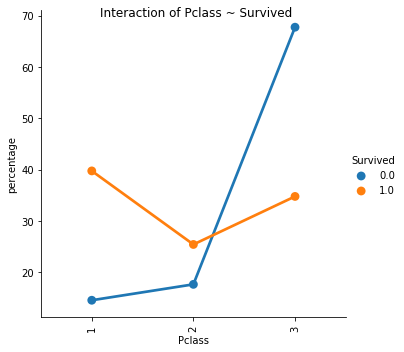

In [9]:
interaction_plot("Survived", feature_name, data)

Observation: The odds of survival seem to be effected by Pclass pretty significantly.

## Name /Categorical, non-binary

In [10]:
# setting the feature name we're examining so that we don't have to re-type it
feature_name = "Name"
# Checking for missing values
data[feature_name].isnull().sum()

0

There are a lot of different unique names in our data set. However, each name has a prefix associated with it. There are way fewer unique values of those prefixes so we'll extract those and create a new feature to draw value from.

In [11]:
# list of all personal titles in our data set
titles = ["Jonkheer.", "Countess.","Lady.","Sir.","Dona.", "Mme.", "Master.", 
          "Rev.", "Don.", "Dr.", "Major.", "Col.", "Capt.", "Mr.", "Mrs.", 
          "Miss.", "Ms.", "Mlle."]
# calling .apply() with the argument axis=1 will apply the lambda function
# argument to each row of the column. The variable x in the lambda represents a 
# row. The funcion extract_title is defined above in our function definitions
# cell. We'll save this as a new feature on our DataFrame called 'Title'
data['Title'] = data.apply(lambda x:
                                extract_title(x[feature_name], titles), axis=1)
# verifying
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr.
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs.
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss.
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs.
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr.


There is probably more value we can etract from the name feature. There are probably many families among our passengers that most likely share last names. If we extract the last name of each passenger it may be useful for identifying family structures.  

In [12]:
# this apply call is very similar to the previous. extract_last_name is 
# also defined above in our function definitions cell. We'll save this as a 
# new feature on our DataFrame called 'LastName'
data['LastName'] = data.apply(lambda x:
                                extract_last_name(x[feature_name]), axis=1)
# verifying
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,LastName
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr.,Braund
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs.,Cumings
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss.,Heikkinen
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs.,Futrelle
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr.,Allen


In [13]:
data[['LastName']].describe()

,LastName
count,1309
unique,875
top,Sage
freq,11


I want to look for names and create a feature based
on the percent mortality rate of that family in the training data.

In [14]:
# this apply call is very similar to the previous. get_fam_mort is 
# also defined above in our function definitions cell. We'll save this as a 
# new feature on our DataFrame called 'FamMort'
data['FamMort'] = data.apply(lambda x:
                        get_fam_mort(x['LastName'], 
                        data[~data["Survived"].isna()], 
                        x),
                        axis=1)
# Individuals that are likely single passengers are encoded as '-1.0', all
# others are encoded as the percentage of likely family members in the 
# training data that perished. We don't want the '-1.0' to have numeric 
# meaning so we're setting this column as a category.
data['FamMort'] = data['FamMort'].astype('category')

# verifying
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,LastName,FamMort
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr.,Braund,-1.0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs.,Cumings,-1.0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss.,Heikkinen,-1.0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs.,Futrelle,-1.0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr.,Allen,-1.0


Now that we've created some features let's analyze them with plots. We'll make an interaction plot for the 'Title' feature.

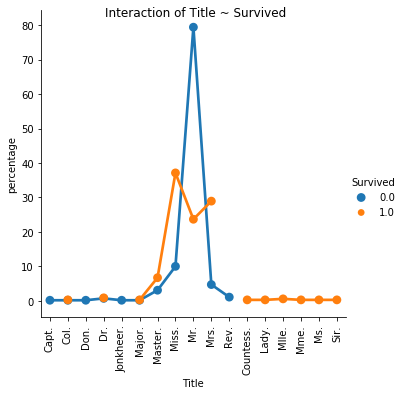

In [15]:
interaction_plot("Survived", 'Title', data)

Observation: Many of the more specialized titles such as 'Countess', 'Lady', 'Mlle', 'Ms', and 'Sir' only show observations that survived. These titles are mostly women and/or upper class titles. All 'Capt', 'Don', and 'Rev' observations perished. 'Mr' is largely the most common and fatal title. </br>Next, we'll make a box and whisker plot for the feature 'FamMort'.

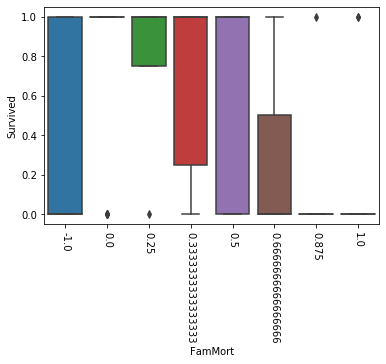

In [16]:
box_plot("FamMort","Survived", data)

Observation: The '-1.0' values have a fairly even mix of Survived and Perished observations. Almost all individuals with 0.0% percent FamMort survived but there are some outliers (the dot). Then as FamMort gets closer to 100.0% the pattern reverses. Non '-1.0' categories appear to be negatively correlated with survival.

In [17]:
data[['FamMort']].describe()

,FamMort
count,1309.0
unique,8.0
top,-1.0
freq,1073.0


Most of the training data consists of individual passengers. Therefore this feaure may not be the most significant but should help with edge cases. 

## Age /Continuous

In [18]:
# setting the feature name we're examining so that we don't have to re-type it
feature_name = "Age"
# Checking for missing values
data[feature_name].isnull().sum()

263

There are 263 missing values. The most basic way of handling these is to impute the mean or median Age. A more intermediate method of handling these is to impute the value based on a relationship with another feature. We'll first check to see if Age is correllated to any of the other numeric features.

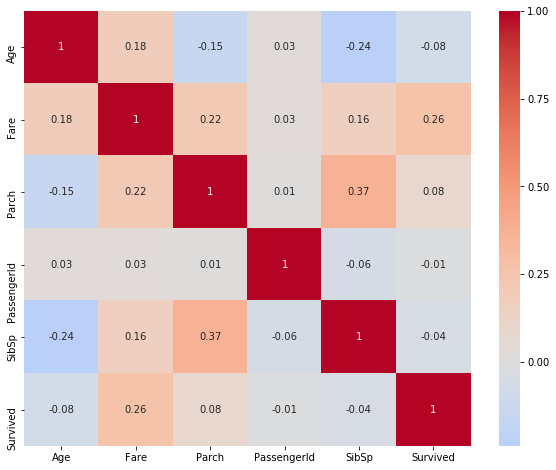

In [19]:
correlation_matrix = data.corr().round(2)
plt.figure(figsize=(10,8))
sb.heatmap(data=correlation_matrix, annot=True, center=0.0, cmap='coolwarm')

The most highly correlated numeric feature is SibSp. However this is not a strong enough relationship to base an imputation on. Next we can look at relationships between Age and the other categorical features.

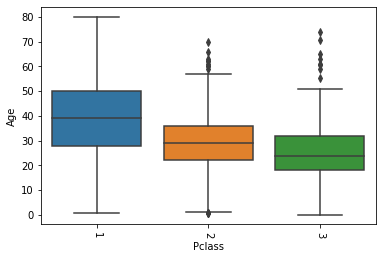

In [21]:
box_plot("Pclass","Age", data)

The most meaningful realtionship among these is between Age and class. We're seeing variation among the means of each class that suggests a trend. We can take the mean value of each class and impute that for our missing Age values based on the missing row's Pclass.

In [21]:
# The impute_age_by_class function is defined above in our function
# definitons. 
data[feature_name] = data.apply(lambda x: impute_age_by_class(x['Pclass'], 
                                                data,
                                                x), axis = 1)

In [23]:
# Now verifying that there are no more null values
data[feature_name].isnull().sum()

0

Text(0, 0.5, 'Frequency')

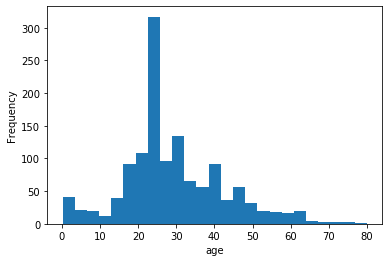

In [24]:
# Next we'll graph the distribution to check for skewness.
x = data[feature_name]
plt.hist(x, bins=25)
plt.xlabel('age')
plt.ylabel('Frequency')

Observation: Looks fairly normal. Not really skewed enough to justify any transformations.
</br>Next we'll min-max scale our numeric variable. We're going to do this to every nuemric variable so that they're all scaled the same.
</br>Min-max scaling is calculated the same in this reference, which also describes why feature scaling is important: https://en.wikipedia.org/wiki/Feature_scaling
</br>The min_max function is defined above in the function definitions cell.

In [26]:
new_feat = f'{feature_name}_scaled'
data[new_feat] = min_max(feature_name, data)
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,LastName,FamMort,Age_scaled
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr.,Braund,-1.0,0.273456
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs.,Cumings,-1.0,0.473882
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss.,Heikkinen,-1.0,0.323563
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs.,Futrelle,-1.0,0.436302
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr.,Allen,-1.0,0.436302


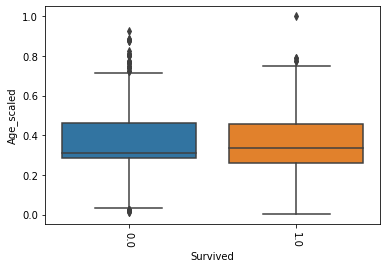

In [38]:
# Next we'll make a box plot to get an idea of how significant the feature
# will be for predicting survival.
box_plot("Survived","Age_scaled", data)

Observation: Probably not that significant. The means and first and thrid quartiles are all very similar to eachother across both groups.

## Fare / Continuous

In [27]:
# setting the feature name we're examining so that we don't have to re-type it
feature_name = "Fare"
# Checking for missing valeus
data[feature_name].isnull().sum()

1

Observation: There is only one missing value. Let's take a look at that row and see if it looks erroneous.

In [28]:
data[data[feature_name].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,LastName,FamMort,Age_scaled
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr.,Storey,-1.0,0.755731


This looks fine. We can impute the value based on another variable like we did last time. If we scroll up to our correlation heatmap in the Age section, we can observe that Fare is again not very highly correlated with the other numeric features. Logically, it's most likely that fare is best explained by which Pclass the individual belongs to. Let's check that with a plot.

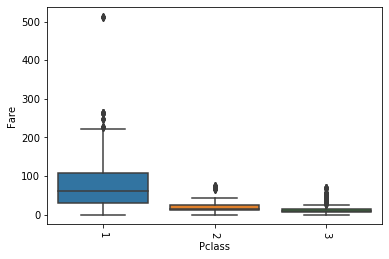

In [31]:
box_plot("Pclass","Fare", data)

In [32]:
# The impute_fare_by_class function is defined above in our function
# definitons. It also works the same as the impute_age_by_class function.
data[feature_name] = data.apply(lambda x: impute_fare_by_class(x['Pclass'], 
                                                data,
                                                x), axis = 1)

Text(0, 0.5, 'Frequency')

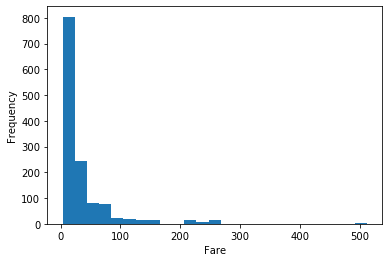

In [34]:
# Next we'll graph the distribution to check for skewness.
x = data[feature_name]
plt.hist(x, bins=25)
plt.xlabel('Fare')
plt.ylabel('Frequency')

Observation: Fare is very right skewed. 
</br>Skewness is explained in the following reference:</br> https://en.wikipedia.org/wiki/Skewness
</br>We should apply the log transformation to this feature to make it more normal.

Text(0, 0.5, 'Frequency')

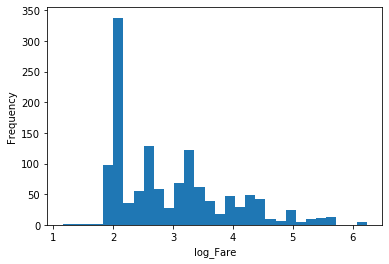

In [35]:
log_fare = np.log(data[feature_name])
x = log_fare
plt.hist(x, bins=30)
plt.xlabel('log_Fare')
plt.ylabel('Frequency')

That looks slightly better. Next, we'll min_max scale it like we did last time.

In [36]:
data['log_Fare'] = log_fare
new_feat = f'log_{feature_name}_scaled'
data[new_feat] = min_max('log_Fare', data)
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,LastName,FamMort,Age_scaled,log_Fare,log_Fare_scaled
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr.,Braund,-1.0,0.273456,1.981001,0.162639
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs.,Cumings,-1.0,0.473882,4.266662,0.612131
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss.,Heikkinen,-1.0,0.323563,2.070022,0.180146
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs.,Futrelle,-1.0,0.436302,3.972177,0.554219
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr.,Allen,-1.0,0.436302,2.085672,0.183223


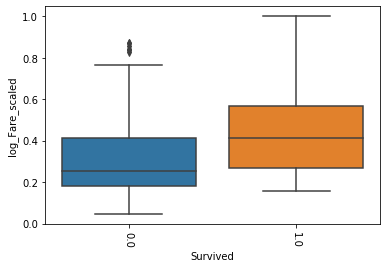

In [39]:
# Next we'll make a box plot to get an idea of how significant the feature
# will be for predicting survival.
box_plot("Survived","log_Fare_scaled", data)

Observation: Probably pretty significant. The means and quartiles vary across groups.

## Cabin / Categorical

In [37]:
# setting the feature name we're examining so that we don't have to re-type it
feature_name = "Cabin"
# checking for missing values
data[feature_name].isnull().sum()

1014

We won't be using cabin because too many of the values are missing. Imputing these missing values based on only the 300 or so cabin observations in our training data would likely just add bias to our data.

## Embarked / Categorical

In [40]:
# setting the feature name we're examining so that we don't have to re-type it
feature_name = "Embarked"
# checking for missing values
data[feature_name].isnull().sum()

2

Observation: There are only two missing values. Let's take a look at those rows and see if they look erroneous.

In [41]:
data[data[feature_name].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,LastName,FamMort,Age_scaled,log_Fare,log_Fare_scaled
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss.,Icard,-1.0,0.473882,4.382027,0.634819
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs.,Stone,-1.0,0.774521,4.382027,0.634819


These look fine. Both observations are first class individuals that paid the same fare. Let's take a look at those relationsips to see if we can impute based on them.

[(0.0, 100.0)]

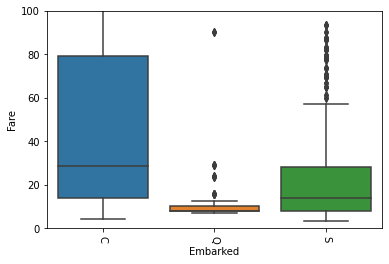

In [35]:
ax = sb.boxplot(x=data['Embarked'], y=data['Fare'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=-90)
ax.set(ylim=(0, 100))

Both individuals paid 80.0 for fare. Based on Embarked factor levels they are most liekly 'C'.

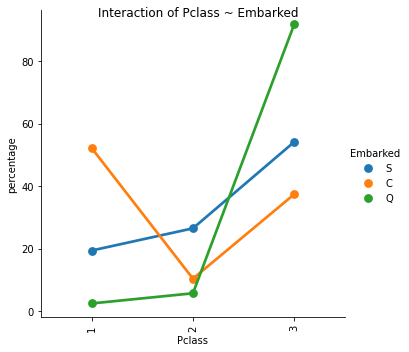

In [36]:
interaction_plot("Embarked", 'Pclass', data)

Both individuals are first class. Based on Embarked they're likely 'C'. We'll imput ethe value 'C' for both of those observations.

In [37]:
data[feature_name] = data[feature_name].fillna('C')

In [38]:
data[feature_name].isnull().sum()

0

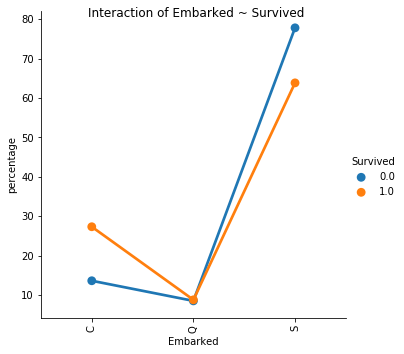

In [43]:
# Next we'll make a box plot to get an idea of how significant the feature
# will be for predicting survival.
interaction_plot("Survived", 'Embarked', data)

This looks like a fairly significant relationsip.
</br>'C' observations were more likely to survive.
</br>'S' observations were more likely to perish.

## Sex / categorical

In [44]:
# setting the feature name we're examining so that we don't have to re-type it
feature_name = "Sex"
# checking for missing values
data[feature_name].isnull().sum()

0

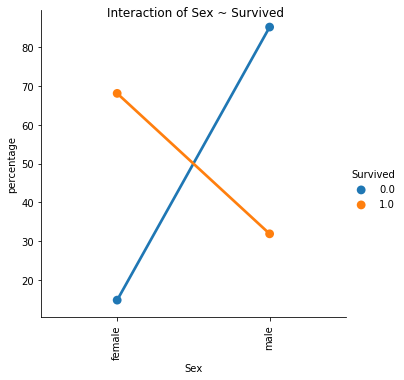

In [46]:
interaction_plot("Survived", 'Sex', data)

This looks fairly significant. Women were more likely to survive.
</br>Men were more likely to perish.

## SibSp / Discrete numerical

In [47]:
# setting the feature name we're examining so that we don't have to re-type it
feature_name = "SibSp"
# checking for missing values
data[feature_name].isnull().sum()

0

In [48]:
data[feature_name].describe()

count    1309.000000
mean        0.498854
std         1.041658
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         8.000000
Name: SibSp, dtype: float64

Text(0, 0.5, 'Frequency')

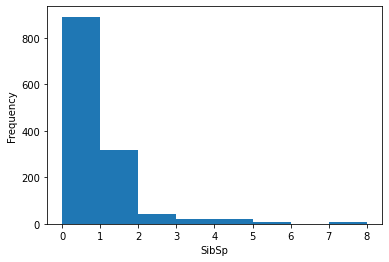

In [43]:
# lets take a look at the graph of the distribution. 
x = data[feature_name]
plt.hist(x, bins=8)
plt.xlabel('SibSp')
plt.ylabel('Frequency')

Observation: The data is right skewed. However, we wont do a log transform this time because the data is discrete. 

In [49]:
# I'll scale the data now.
data[f'{feature_name}_scaled'] = min_max(feature_name, data)

In [50]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,LastName,FamMort,Age_scaled,log_Fare,log_Fare_scaled,SibSp_scaled
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr.,Braund,-1.0,0.273456,1.981001,0.162639,0.125
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs.,Cumings,-1.0,0.473882,4.266662,0.612131,0.125
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss.,Heikkinen,-1.0,0.323563,2.070022,0.180146,0.000
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs.,Futrelle,-1.0,0.436302,3.972177,0.554219,0.125
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr.,Allen,-1.0,0.436302,2.085672,0.183223,0.000


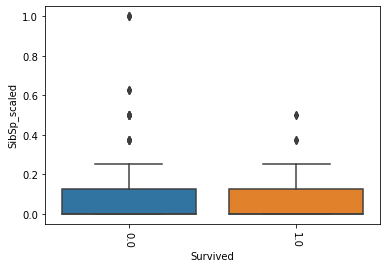

In [52]:
# Next we'll make a box plot to get an idea of how significant the feature
# will be for predicting survival.
box_plot("Survived","SibSp_scaled", data)

These are essentially the same. We won't be using this during modelling.

## Parch / Numeric discrete

In [53]:
# setting the feature name we're examining so that we don't have to re-type it
feature_name = "Parch"
# checking for missing values
data[feature_name].isnull().sum()

0

In [54]:
data[feature_name].describe()

count    1309.000000
mean        0.385027
std         0.865560
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         9.000000
Name: Parch, dtype: float64

Text(0, 0.5, 'Frequency')

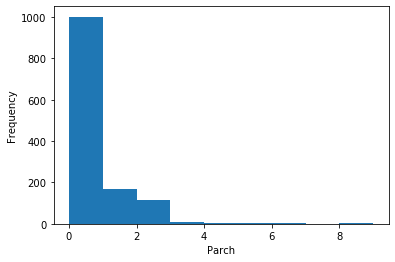

In [55]:
x = data[feature_name]
plt.hist(x, bins=9)
plt.xlabel('Parch')
plt.ylabel('Frequency')

Observation: The data is right skewed. However, again, we wont do a log transform this time because the data is discrete. 

In [57]:
# I'll scale the data now.
data[f'{feature_name}_scaled'] = min_max(feature_name, data)

In [58]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,LastName,FamMort,Age_scaled,log_Fare,log_Fare_scaled,SibSp_scaled,Parch_scaled
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr.,Braund,-1.0,0.273456,1.981001,0.162639,0.125,0.0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs.,Cumings,-1.0,0.473882,4.266662,0.612131,0.125,0.0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss.,Heikkinen,-1.0,0.323563,2.070022,0.180146,0.000,0.0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs.,Futrelle,-1.0,0.436302,3.972177,0.554219,0.125,0.0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr.,Allen,-1.0,0.436302,2.085672,0.183223,0.000,0.0


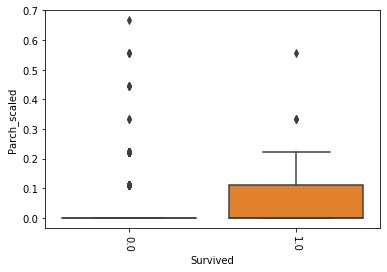

In [59]:
box_plot("Survived","Parch_scaled", data)

These are fairly significant. It appears individuals with more parents on board were more likely to survive.

# Splitting into train and test
Now, we'll split our data back up into the original train and test sets. We'll also select the most significant features that we found during preprocessing. First we'll create dummy variables so that our models can ingest our categorical data.
</br>Dummy variables are explained in the following reference: </br>https://en.wikipedia.org/wiki/Dummy_variable_(statistics)

In [76]:
# dummies
X_dummies = pd.get_dummies(data[["Parch_scaled", "log_Fare_scaled", "FamMort", 
                                 "Title", "Pclass", "Embarked", "Sex"]])
# splitting
X_dummies_train = X_dummies.iloc[0:890]
X_dummies_test = X_dummies.iloc[891:]

# creating labels column
Y = data.iloc[0:890]["Survived"]
# creating dataframe to store predictions
test_frame = pd.DataFrame(data.iloc[891:]["PassengerId"])

Next we'll split our training and testing data into dataframes containing only categorical and only numeric data. Some models can only take one type of data at a time, so in those cases we'll have to feed them in seperatly and use an aggregate model to get a prediction from both.

In [77]:
# creating categorical frames
X_dummies_cat = X_dummies_train.drop(["Parch_scaled", "log_Fare_scaled"],
                                     axis = 1)
X_dummies_cat_t = X_dummies_test.drop(["Parch_scaled",  "log_Fare_scaled"], 
                                      axis = 1)
# creating numeric frames
X_num = X_dummies_train[["Parch_scaled", "log_Fare_scaled"]]
X_num_t = X_dummies_test[["Parch_scaled", "log_Fare_scaled"]]

In [78]:
# creating data frames to store our predicted probabilities in. We can add
# predicted probabilites to this as we model and then analyze Mean Squared
# Error at the end to evaluate them.
train_result_frame = pd.DataFrame(Y)
test_result_frame = pd.DataFrame()

# Model training & validation

I'll do a walkthrough of modelling the simplest classification models that apply to this situation. Then we'll do a Neural Net example.

## Decision Tree
A decision tree is probably the simlest model we can apply.
They are explained in the following reference:
</br>https://en.wikipedia.org/wiki/Decision_tree_learning

In [79]:
# first step is setting up cross validation. The function train_test_split
# will randomly split our training set into training and a validation set. 
# validation sets are used to get an idea of how well the model will
# perform on unseen data.
x_train, x_valid, y_train, y_valid = train_test_split(
    X_dummies_train, Y, test_size=0.25, random_state=0)

In [80]:
# fitting
clf = tree.DecisionTreeClassifier().fit(x_train, y_train)
# checking accuracy on validation set
clf.score(x_valid, y_valid)

0.8251121076233184

In [81]:
# fitting on entire training set
clf = tree.DecisionTreeClassifier().fit(X_dummies_train, Y)
# predicting on the test set
test_frame["Survived"] = clf.predict(X_dummies_test).astype('int32')
# writing to a file
test_frame.to_csv('./predictions/decision_tree.csv', index = False)

# storing the predicted probabilities in dataframe for MSE analysis
train_result_frame['dt'] = [x[1] for x in clf.predict_proba(X_dummies_train)]
test_result_frame['dt'] = [x[1] for x in clf.predict_proba(X_dummies_test)]

## Logistic Regression
Logistic regression is essentially regular linear regression mapped onto the odds domain using the sigmoid activation function. Using this technique a regression model can be used to classify. See the following reference for more detail:
</br> https://en.wikipedia.org/wiki/Logistic_regression

In [82]:
# creating training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(
    X_dummies_train, Y, test_size=0.25, random_state=0)

In [83]:
# fitting 
logr = LogisticRegression(solver = 'lbfgs').fit(x_train, y_train)
# checking validation accuracy
logr.score(x_valid, y_valid)

0.8295964125560538

In [84]:
# fitting to full training data
logr = LogisticRegression(solver = 'lbfgs').fit(X_dummies_train, Y)
# predicting the test set
test_frame["Survived"] = logr.predict(X_dummies_test).astype('int32')
# writing results to a file
test_frame.to_csv('./predictions/logistic_reg.csv', index = False)

# storing the predicted probabilities in dataframe for MSE analysis
train_result_frame['logr'] = [x[1] for x in 
                                  logr.predict_proba(X_dummies_train)]
test_result_frame['logr'] = [x[1] for x in 
                                 logr.predict_proba(X_dummies_test)]

## Random Forest
A random forest is a very powerful ensemble model. It uses a decision tree as its underlying model and a applies a method know as bagging (bootstrap aggregation). Bagging works by taking many random samples with replacement from the training data. A model (decision tree) is fitted to every random sample. The predicted result is the majority voted classification of the underlying trees. The advantage bagging gives is that it reduces variance without adding bias. For more information check this reference:
</br>https://en.wikipedia.org/wiki/Random_forest
</br>For more information on the bias-variance tradeoff check this reference:
</br>https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff
</br>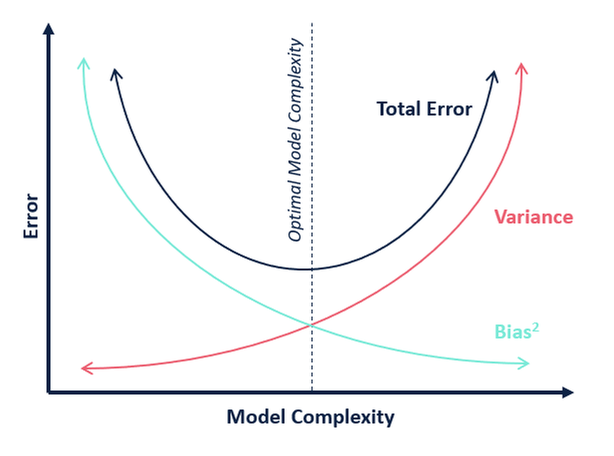

Random forest is a more complex model than the previous models that we've fit. We'll have to do hyper-parameter tuning. Hyper-parameters are the parameters of our model that act as a mode of control for how the model fits the data. Tuning is completed by varying the hyper-parameters and cross validating the model for each variation. To accomplish this we'll use RandomizedSearchCV from sklearn. It utilizes parallel processing to speed up the process.

In [85]:
# the number of random samples and decision trees to build
n_estimators = [100, 200, 500, 600, 750, 1000, 1250]
# the min number of samples allowed at each decision tree node (controls
# against overfitting)
min_samples_split = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
# the min number of samples allowed at each decision tree leaf (controls
# against overfitting)
min_samples_leaf = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
# placing the parameter values into a dictionary
grid_param = {'n_estimators': n_estimators,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

# initializing the model with a random state
random_forest = rfc(random_state=4538756)

# initializing the cross validator 
RFC_random = RandomizedSearchCV(estimator = random_forest, 
                             param_distributions = grid_param,
                             n_iter = 120,
                             verbose=2,
                             cv = 5,
                             random_state = 857436,
                             n_jobs = -1)
# starting the tuner
RFC_random.fit(X_dummies_train, Y)
print(RFC_random.best_params_)
print(f'score: {RFC_random.best_score_}')

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.1min finished


{'n_estimators': 750, 'min_samples_split': 10, 'min_samples_leaf': 5}
score: 0.8393258426966292


In [86]:
# initializing the mdoel using best selected hyper-parameters
random_forest = rfc(n_estimators = 750, min_samples_split = 10, 
                    min_samples_leaf = 5, random_state = 27394652)
# fitting to entire training set
randf = random_forest.fit(X_dummies_train, Y)
# predicting the test set
test_frame["Survived"] = randf.predict(X_dummies_test).astype('int32')
# writing to a file
test_frame.to_csv('./predictions/random_forest.csv', index = False)

# storing the predicted probabilities in dataframe for MSE analysis
train_result_frame['randf'] = [x[1] for x in 
                                  randf.predict_proba(X_dummies_train)]
test_result_frame['randf'] = [x[1] for x in 
                                 randf.predict_proba(X_dummies_test)]

## Gradient Boosted Trees
Gradient Boosting is another very powerful ensemble model. Here it uses decision trees again as the underlying model. Boosting, however, unlike bagging works sequentially instead of in parallel. It also utilizes random sampling with replacement. However the random sampling is weighted. For each random sample that is drawn and modelled and predicted the resulting residual errors are used as sample weights for the next sampling. This way the Gradient boosted model trains more on hard to predict observtations. Gradient boosting reduces bias without adding variance.</br>
Gradient boosted Trees should work better for the titanic problem because it represents the imbalanced class problem. The hard to predict observations are the Survived individuals because there are proportionally less than them than those that perished.
</br>For more information on the imbalanced class problem check the following reference:
</br>https://towardsdatascience.com/class-imbalance-a-classification-headache-1939297ff4a4
</br>For more information on gradient boosted trees check the following refrence:
</br>https://en.wikipedia.org/wiki/Gradient_boosting

In [88]:
# the number of trees to build
n_estimators = [100, 250, 500, 750, 1000, 1250]
# the learning rate to apply with every tree built
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3]
# the min number of samples allowed at each decision tree node (controls
# against overfitting)
min_samples_split = [20, 25, 30, 35, 40, 45, 50, 55]
# the min number of samples allowed at each decision tree leaf (controls
# against overfitting)
min_samples_leaf = [20, 25, 30, 35, 40, 45, 50, 55]
# placing the parameter values into a dictionary
grid_param = {'n_estimators': n_estimators,
              'learning_rate': learning_rate,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

# initialize model with a random state
gradient_boosted_trees = gbc(random_state=24352345)
# initialize the cross validator
GB_random = RandomizedSearchCV(estimator = gradient_boosted_trees, 
                             param_distributions = grid_param,
                             n_iter = 120,
                             verbose=2,
                             cv = 5,
                             random_state = 47567,
                             n_jobs = -1)
# starting the tuner
GB_random.fit(X_dummies_train, Y)
# print result
print(GB_random.best_params_)
print(f'score: {GB_random.best_score_}')

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   42.2s finished


{'n_estimators': 1000, 'min_samples_split': 45, 'min_samples_leaf': 20, 'learning_rate': 0.05}
score: 0.852808988764045


In [89]:
# initializing the mdoel using best selected hyper-parameters
grad_booster = gbc(n_estimators = 1000, min_samples_split = 45, 
                    min_samples_leaf = 20, learning_rate = 0.05, 
                   random_state = 34737)
# fitting to entire training set
gradb = grad_booster.fit(X_dummies_train, Y)
# predicting the test set
test_frame["Survived"] = gradb.predict(X_dummies_test).astype('int32')
# writing to a file
test_frame.to_csv('./predictions/gradient_boosted_trees.csv', index = False)

# storing the predicted probabilities in dataframe for MSE analysis
train_result_frame['gbc'] = [x[1] for x in 
                                  gradb.predict_proba(X_dummies_train)]
test_result_frame['gbc'] = [x[1] for x in 
                                 gradb.predict_proba(X_dummies_test)]

## K-Nearest Neighbors - Categorgical Jaccard
K-NN is a very simple model. It takes in the training set, calculates a distance metric for each training observation, and stores it. For each new observation to predict, K-NN calculates the same distance metric and find the K neighbors in the training data with distance metrics closest to the distance metric of the new data. K-NN takes the majority class vote from those K neighbors and assigns it to the new data. 
</br>For more information on K-NN check the following reference:
</br>https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm
</br>K-NN is dependent on the distance metric. For that reason we shouldn't pass in both the numeric and categorical data at once. First we'll train and predict just the categorical data. We'll use the distance metric called the 'Jaccard Index'. It is built specifically for determining the similarity of two boolean vectors. 
</br>For more information on the Jaccard Index check the following reference:
</br>https://en.wikipedia.org/wiki/Jaccard_index

In [90]:
# define the values of k to test
k = [5, 11, 15, 21, 25, 31, 35, 41, 45, 51, 55, 61, 65, 71, 75, 81, 85, 91]
# placing the parameter values into a dictionary
grid_param = {'n_neighbors': k}

# initialize model with given distance metric
model = knn(metric = 'jaccard')
# initialize the cross validator
KNN_random = GridSearchCV(estimator = model, 
                             param_grid = grid_param,
                             verbose = 2,
                             cv = 5,
                             n_jobs = -1)
# begin tuning
KNN_random.fit(X_dummies_cat, Y)
# print results
print(KNN_random.best_params_)
print(f'score: {KNN_random.best_score_}')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.2s


{'n_neighbors': 11}
score: 0.8382022471910112


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.4s finished


In [91]:
# initializing the mdoel using best selected hyper-parameters
knn_grad = knn(metric = 'jaccard', n_neighbors = 11)
# fitting to entire training set
knn_c = knn_grad.fit(X_dummies_cat, Y)
# predicting the test set
test_frame["Survived"] = knn_c.predict(X_dummies_cat_t).astype('int32')
# writing to a file
test_frame.to_csv('./predictions/knn_categorical.csv', index = False)

# storing the predicted probabilities in dataframe for MSE analysis
train_result_frame['knn_cat'] = [x[1] for x in 
                                  knn_c.predict_proba(X_dummies_cat)]
test_result_frame['knn_cat'] = [x[1] for x in 
                                 knn_c.predict_proba(X_dummies_cat_t)]

## K-Nearest Neighbors - Numeric Vector norm
We'll now train another K-NN model on only the Numeric data. This time we'll use the 'eclidean' distance metric. This K-NN model will calculate vector norms co compare data.
</br>For more information on the Euclidean distance metric check the following reference:
</br>https://en.wikipedia.org/wiki/Euclidean_distance

In [94]:
# define the values of k to test
k = [5, 11, 15, 21, 25, 31, 35, 41, 45, 51, 55, 61, 65, 71, 75, 81, 85, 91]
# placing the parameter values into a dictionary
grid_param = {'n_neighbors': k}

# initialize model with given distance metric
model = knn(metric = 'euclidean')
# initialize the cross validator
KNN_random = GridSearchCV(estimator = model, 
                             param_grid = grid_param,
                             verbose = 2,
                             cv = 5,
                             n_jobs = -1)
# begin tuning
KNN_random.fit(X_num, Y)
# print results
print(KNN_random.best_params_)
print(f'score: {KNN_random.best_score_}')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s


{'n_neighbors': 61}
score: 0.6797752808988764


[Parallel(n_jobs=-1)]: Done  67 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished
c:\users\woybo\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [95]:
# initializing the mdoel using best selected hyper-parameters
knn_grad = knn(metric = 'euclidean', n_neighbors = 61)
# fitting to entire training set
knn_c = knn_grad.fit(X_num, Y)
# predicting the test set
test_frame["Survived"] = knn_c.predict(X_num_t).astype('int32')
# writing to a file
test_frame.to_csv('./predictions/knn_numeric.csv', index = False)

# storing the predicted probabilities in dataframe for MSE analysis
train_result_frame['knn_num'] = [x[1] for x in 
                                  knn_c.predict_proba(X_num)]
test_result_frame['knn_num'] = [x[1] for x in 
                                 knn_c.predict_proba(X_num_t)]

## K-Nearest Neighbors - Combined Numeric and categorical
Now we'll train K-NN models on the categorical data and the numeric data. We'll output their predicted probabilities to a new dataframe and then train a K-NN model using the euclidean distance metric. This will work because both features (Numeric prob) and (Categorical prob) are both in the probability domain and scaled the same.

In [96]:
# fitting K-NN numeric with the best selected hyperparameters
knn_num = knn(metric = 'euclidean', n_neighbors = 61)
knn_num.fit(X_num, Y)
# fitting K-NN categorical with the best selected hyperparameters
knn_cat = knn(metric = 'jaccard', n_neighbors = 11)
knn_cat.fit(X_dummies_cat, Y)

# creating a data frame to store the probablities in
frame = pd.DataFrame(Y)
# saving calculated probabilities for the numeric training data
frame["num_prob"] = [x[1] for x in knn_num.predict_proba(X_num)]
# saving calculated probabilities for the categorical training data
frame["cat_prob"] = [x[1] for x in knn_cat.predict_proba(X_dummies_cat)]

# define the values of k to test
k = [5, 11, 15, 21, 25, 31, 35, 41, 45, 51, 55, 61, 65, 71, 75, 81, 85, 91]
# placing the parameter values into a dictionary
grid_param = {'n_neighbors': k}

# initialize model with given distance metric
knn_full = knn(metric = 'euclidean')
# initialize the cross validator
KNN_random = GridSearchCV(estimator = knn_full, 
                             param_grid = grid_param,
                             verbose = 2,
                             cv = 5,
                             n_jobs = -1)
# begin tuning
KNN_random.fit(frame[["num_prob", "cat_prob"]], frame["Survived"])
# print results
print(KNN_random.best_params_)
print(f'score: {KNN_random.best_score_}')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


{'n_neighbors': 31}
score: 0.8393258426966292


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished


In [97]:
# fitting K-NN numeric with the best selected hyperparameters
knn_num = knn(metric = 'euclidean', n_neighbors = 61)
knn_num.fit(X_num, Y)
# fitting K-NN categorical with the best selected hyperparameters
knn_cat = knn(metric = 'jaccard', n_neighbors = 11)
knn_cat.fit(X_dummies_cat, Y)

# creating a data frame to store the training probablities in
frame = pd.DataFrame(Y)
# saving calculated probabilities for the numeric training data
frame["num_prob"] = [x[1] for x in knn_num.predict_proba(X_num)]
# saving calculated probabilities for the categorical training data
frame["cat_prob"] = [x[1] for x in knn_cat.predict_proba(X_dummies_cat)]

# creating a data frame to store the test probablities in
frame_test = pd.DataFrame()
# saving calculated probabilities for the numeric test data
frame_test["num_prob"] = [x[1] for x in knn_num.predict_proba(X_num_t)]
# saving calculated probabilities for the categorical test data
frame_test["cat_prob"] = [x[1] for x in knn_cat.predict_proba(X_dummies_cat_t)]

# fitting full K-NN with the best selected hyperparameters
knn_full = knn(metric = 'euclidean', n_neighbors = 31)
knn_full = knn_full.fit(frame[["num_prob", "cat_prob"]], frame["Survived"])

# predicting on the test set probabilities
test_frame["Survived"] = knn_full.predict(
    frame_test[["num_prob", "cat_prob"]]
).astype('int32')
# saving the predictions
test_frame.to_csv('./predictions/knn_full.csv', index = False)

# storing the predicted probabilities in dataframe for MSE analysis
train_result_frame['knn'] = [x[1] for x in 
                                  knn_full.predict_proba(
                                      frame[["num_prob", "cat_prob"]])]
test_result_frame['knn'] = [x[1] for x in 
                                 knn_full.predict_proba(
                                     frame_test[["num_prob", "cat_prob"]])]

## Defining a Neural Network
The first step of building and training a Neural Network is defining one. The function create_neural_net will do just that for us. All layers we add will use the Relu activation function, except the output layer which will use the sigmoid activation function. 
</br>For more information on the Relu activation function check the following reference:
</br>https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
</br>For more information on the Sigmoid activation function check the following reference:
</br>https://en.wikipedia.org/wiki/Sigmoid_function
</br>We'll also use the Adam optimizer which implements and adaptive learning rate. For more information on the Adam optimizer check the following reference:
</br>https://medium.com/@nishantnikhil/adam-optimizer-notes-ddac4fd7218
</br>We'll also add a dropout layer to help prevent overfitting. For more information on dropout check the following reference:
</br>https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

In [98]:
def create_neural_net(in_shape, lyrs=[4], act='relu', opt='Adam', dr=0.0):
    # set random seed for reproducibility
    seed(37556)
    tf.random.set_seed(37556)
    
    # initialize the model object
    model = Sequential()
    
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=in_shape, activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    
    # add dropout, default is none
    model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [99]:
# creating a neural network
single_net = create_neural_net(X_dummies_train.shape[1], lyrs =[4])
single_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 148       
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [100]:
# fitting the network to the training data with arbitrary hyper-parameters.
# this is just an example to show off some cool things keras can do.
training = single_net.fit(X_dummies_train, Y, epochs=100, batch_size=32,
                         validation_split=0.25, verbose=0)
# outputting the validation accuracy
val_acc = np.mean(training.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 83.56%


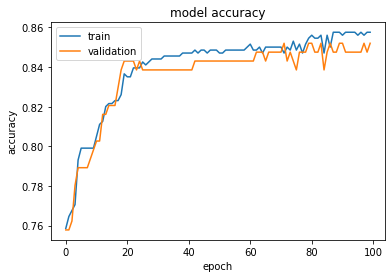

In [101]:
# plotting the training history
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Neural Network
Now we'll use the above function to create a neural network and tune the hyper-parameters. For more information on Neural Networks check the following reference:
</br>https://en.wikipedia.org/wiki/Artificial_neural_network

In [102]:
# wrap the nerual network in an sklearn class so we can plug it into 
# RandomizedSearchCV
neural_net = KerasClassifier(build_fn=create_neural_net, 
                             in_shape = X_dummies_train.shape[1], verbose = 0)
# defining the batch size
batch_size = [1, 16, 32, 64]
# defining the number of epochs
epochs = [25, 50, 100, 150]
# defining the size and number of layers
layers = [[4], [8], [12], [4, 4], [8, 4], [8, 8], [12, 8], [12, 4], [12, 8, 4]]
# defining the rate of the dropout layer
drops = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]

# initialize model with given hyper-parameters
grid_param = {'batch_size': batch_size,
             'epochs': epochs,
             'dr': drops,
            'lyrs': layers}
# initialize the cross validator
nn_random = RandomizedSearchCV(estimator = neural_net, 
                             param_distributions = grid_param,
                             n_iter = 200,
                             verbose=2,
                             cv = 5,
                             random_state = 456745,
                             n_jobs = -1)
# begin tuning
nn_random.fit(X_dummies_train, Y)

# print results
print(nn_random.best_params_)
print(f'score: {nn_random.best_score_}')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 29.6min finished


{'lyrs': [12, 8, 4], 'epochs': 50, 'dr': 0.1, 'batch_size': 1}
score: 0.8561797738075256


In [103]:
# initializing the mdoel using best selected hyper-parameters
nn = KerasClassifier(build_fn=create_neural_net, 
                        in_shape = X_dummies_train.shape[1],
                        lyrs=[12, 8, 4], epochs=50, dr=0.1, batch_size=1, 
                         verbose=0)
# fitting to entire training set
nn.fit(X_dummies_train, Y)
# predicting the entire test set
test_frame["Survived"] = nn.predict(X_dummies_test).astype('int32')
# writing to a file
test_frame.to_csv('./predictions/nn.csv', index = False)

# storing the predicted probabilities in dataframe for MSE analysis
train_result_frame['nn'] = [x[1] for x in 
                                  nn.predict_proba(X_dummies_train)]
test_result_frame['nn'] = [x[1] for x in 
                                 nn.predict_proba(X_dummies_test)]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use `model.predict()` instead.


Instructions for updating:
Please use `model.predict()` instead.


# Results
Now that we're done with modelling we can analyze the MSE (Mean Squared Error) of each of our models. For more information on MSE check the following reference:
</br>https://en.wikipedia.org/wiki/Mean_squared_error

In [104]:
test_result_frame.to_csv('./result_data/test_results.csv', index = False)
#test_result_frame = pd.read_csv('./result_data/test_results.csv')

train_result_frame.to_csv('./result_data/train_results.csv', index = False)
#train_result_frame = pd.read_csv('./result_data/train_results.csv')
train_result_frame.head()

,Survived,dt,logr,randf,gbc,knn_cat,knn_num,knn,nn
0,0.0,0.000000,0.080191,0.097471,0.042651,0.090909,0.180328,0.064516,0.123582
1,1.0,1.000000,0.956367,0.950157,0.998871,1.000000,0.655738,1.000000,0.996781
2,1.0,0.500000,0.629976,0.461371,0.526554,0.454545,0.196721,0.387097,0.396768
3,1.0,1.000000,0.934691,0.937721,0.994400,1.000000,0.590164,1.000000,0.997934
4,0.0,0.121951,0.080579,0.127776,0.125205,0.090909,0.213115,0.096774,0.126102


In [105]:
mse = {col: 0 for col in train_result_frame.columns if col != "Survived"}
for col in mse:
    error = mse[col]
    for _,row in train_result_frame[['Survived', col]].iterrows():
        error += math.pow(row['Survived'] - row[col], 2)
    error /= train_result_frame.shape[0]
    mse[col] = error

In [106]:
for k, v in sorted(mse.items(), key=lambda item: item[1]):
    print(f'{k:10} MSE: {mse[k]:.3f}')

dt         MSE: 0.050
gbc        MSE: 0.071
nn         MSE: 0.097
randf      MSE: 0.109
knn        MSE: 0.112
logr       MSE: 0.113
knn_cat    MSE: 0.116
knn_num    MSE: 0.204
